# Solving the Traveling Salesman Problem with Ant Colony Optimization 

**by Filipe Chagas Ferraz**

![](tsp-aco-filipe.gif)

Ant Colony Optimization (ACO) is a metaheuristic algorithm that performs well in solving path optimization problems, such as the Traveling Salesman Problem (TSP), by simulating the behavior of ants searching for food. In this notebook, ACO is implemented and explored as a TSP solver.

## Traveling Salesman Problem 

The Traveling Salesman Problem (TSP) is a classic optimization problem where a salesman must visit a set of cities exactly once and return to the starting city, with the goal of minimizing the total travel distance or cost. Given the high number of possible routes as the number of cities grows, TSP is computationally challenging and is classified as an NP-hard problem. It has applications in logistics, manufacturing, and route planning, and is commonly solved using heuristic, approximation, or exact algorithms.

Formally, the TSP consists in finding, for a graph of $N$ points $\{p_1, p_2, ..., p_N\}$ and $N^2-N$ non-zero distances $\{d_{i,j}\}_{i \neq j}$, a closed path that connects all points with minimum total distance. As it is an NP-hard problem, there is no exact algorithm to solve it in tractable time. Therefore, in practice, instead of solving it exactly, we use metaheuristic optimization algorithms to obtain solutions that are good enough. In this notebook, the ACO algorithm is used, but other metaheuristic algorithms can be used (see: [Solving the Traveling Salesman Problem with Simulated Annealing](https://github.com/FilipeChagasDev/FilipeChagasDev/blob/main/notebooks/traveling-salesman/traveling-salesman-sa-tutorial.ipynb)).

## Ant Colony Optimization

The Ant Colony Optimization (ACO) algorithm searches for an optimal path by imitating the behavior of ants searching for food. The first ants leaving the anthill walk along random paths, leaving pheromone trails. The next ants that go out to search for food tend to follow the existing pheromone trails. As the pheromone evaporates over time, the path with the highest pheromone concentration becomes the most efficient route to the food. In this way, the best path found by the ants becomes the preferred one, while other paths tend to be tested less and less.

There are some variations of the ACO algorithm, but in this notebook, it is implemented as follows:

1. Initialize:
    - Define the number of ants ($n_\text{ants}$), the number of optimization epochs ($n_\text{epochs}$), e the paramethers ($\alpha$, $\beta$ and $\rho$).
    - For each edge connecting a pair of points $p_i$ and $p_j$:
        - Initialize the pheromone entry $\tau_{i,j}$ with 1.
    - Define variables to hold the best solution found: 
        - $W \leftarrow \emptyset$ to the best path;
        - $L \leftarrow \infty $ to the best length.
2. For each optimization epoch:
    - For each $k$-th ant ($1 \leq k \leq n_\text{ants}$):
        - Define a list $w=[\emptyset,...,\emptyset]_N$ of visited point indexes to the $k$-th ant. 
        - Place the $k$-th ant at an initial random point (i.e., $w_1 \leftarrow r$ where $r \sim \mathcal{U}(1,N)$).
        - For each non-initial position $t\leftarrow 2,...,N$ in the path:
            - Get the last visited point index $i := w_{t-1}$.
            - Chose the current point index $w_t$ to visit as some $j$ following the probability distribution 
            $$P(w_t\leftarrow j \mid w_{t-1}=i) = 
            \frac{(\tau_{i,j})^\alpha (d_{i,j})^{-\beta}}
            {\sum_{k \not\in w} (\tau_{i,k})^\alpha (d_{i,k})^{-\beta}}$$
        - calculate the path length $l = \sum_{t} d_{w_t, w_{t+1}}$.
        - if $l < L$, then: 
            - $L \leftarrow l$
            - $W \leftarrow w$

    - Update the pheromone distribution:
        - For each pair of point indexes $(i, j)$:
            - Do $\tau_{i,j} \leftarrow (1 - \rho)\tau_{i,j}$ to evaporate the pheromone
        - For each pair $(i,j):=(W_t, W_{t+1})$ in the path:
            - Do $\tau_{i,j} \leftarrow \tau_{i,j} + Q/L$ to create a new pheromone trail.
3. Return $(W,L)$ as the solution.

in this particular implementation, $Q$ is defined as $\mu N - 2\sigma\sqrt{N}$, where $\mu$ is the average of all distances between pairs of points in the map, and $\sigma$ is the standard deviation of these distances. $Q$ in this case is the expected path length with $Z=-2$ from a normal distribution of path lengths centered at $\mu N$. 

## Implementation


In the next cell, the packages used are imported.

In [1]:
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In the next cell, the ACO algorithm is implemented as a class.

In [ ]:
class AntColonyOptimizer():
    def __init__(self, distance_matrix: np.ndarray, n_ants: int, n_epochs: int, alpha: float, beta: float, rho: float):
        # Params:
        #   distance_matrix: Numpy 2D array where each distance_matrix[i,j] is the distance between the i-th and j-th points.
        #   n_ants: number of ants walking together on each epoch.
        #   n_epochs: number of optimization epochs/iterations.
        #   alpha and beta: hyperparameters of the move probability distribution.
        #   rho: pheromone evaporation rate.
        assert n_ants > 0
        assert n_epochs > 0
        assert distance_matrix.shape[0] == distance_matrix.shape[1]
        assert distance_matrix.shape[0] > 1
        self.n_ants = n_ants
        self.n_epochs = n_epochs
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.distance_matrix = distance_matrix
        self.symmetric = np.all(distance_matrix == distance_matrix.T) # True if the graph is not directed
        self.n_points = distance_matrix.shape[0]
        self.q = np.mean(distance_matrix)*self.n_points - 2*np.std(distance_matrix)*np.sqrt(self.n_points)
        self.pheromone = np.ones(shape=(self.n_points, self.n_points))
        self.best_path = None
        self.best_length = float('inf')
    

    def __move_probs(self, visited: np.ndarray, curr_point: int) -> np.ndarray:
        # Method that returns the probability distribution of moving from a current point to each unvisited point
        # Params:
        #   visited: Numpy 1D array of booleans. If visited[i] is True, then the i-th point is already visited.
        #   curr_point: index of the current point.
        assert 0 <= curr_point < self.n_points
        assert visited.dtype == bool
        probs = np.zeros(self.n_points)
        for j in range(self.n_points):
            if not visited[j]:
                probs[j] = self.pheromone[curr_point, j]**self.alpha * (1/self.distance_matrix[curr_point, j])**self.beta
        probs /= np.sum(probs)
        return probs
    

    def __path_length(self, path: np.ndarray) -> float:
        # Calculates the length of a given path.
        # Params:
        #   path: Numpy 1D array of point indexes.
        assert path.shape == (self.n_points,)
        length = 0
        for i in range(self.n_points-1):
            length += self.distance_matrix[path[i], path[i+1]]
        length += self.distance_matrix[path[-1], path[0]]
        return length


    def __ant_walk(self) -> tuple:
        # Simulates the walk of a single ant.
        # Returns the path walked by the ant and it's length.
        visited = np.zeros(self.n_points, dtype=bool)
        path = np.zeros(self.n_points, dtype=int)
        path[0] = np.random.randint(0, self.n_points)
        visited[path[0]] = True
        for i in range(1, self.n_points):
            probs = self.__move_probs(visited, path[i-1])
            chosen_point = np.random.choice(np.arange(self.n_points), p=probs)
            path[i] = chosen_point
            visited[chosen_point] = True
        return path, self.__path_length(path)
    

    def __update_pheromone(self):
        # Method that updates the pheromone distribution.
        assert self.best_path is not None

        self.pheromone *= 1 - self.rho # Evaporate pheromone
        
        for i in range(self.n_points-1):
            self.pheromone[self.best_path[i], self.best_path[i+1]] += self.q/self.best_length
            if self.symmetric:
                self.pheromone[self.best_path[i+1], self.best_path[i]] = self.pheromone[self.best_path[i], self.best_path[i+1]]
        
        self.pheromone[self.best_path[-1], self.best_path[0]] += self.q/self.best_length
        if self.symmetric:
            self.pheromone[self.best_path[0], self.best_path[-1]] = self.pheromone[self.best_path[-1], self.best_path[0]]


    def __optim_step(self):
        # Perform a single optimization epoch.
        for k in range(self.n_ants):
            path, length = self.__ant_walk()
            if self.best_length > length:
                self.best_length = length
                self.best_path = path
        self.__update_pheromone()
    

    def optimize(self, path_history: list = None, length_history: list = None, pheromone_history: list = None):
        # Perform the complete optimization process. 
        # Params:
        #   path_history: list where the best path at each epoch is added.
        #   length_history: list where the best length at each epoch is added.
        #   pheromone_history: list where the pheromone distribution matrix at each epoch is added.
        for i in range(self.n_epochs):
            self.__optim_step()
            
            if path_history is not None:
                path_history.append(self.best_path.copy())

            if length_history is not None:
                length_history.append(self.best_length.copy())

            if pheromone_history is not None:
                pheromone_history.append(self.pheromone.copy())

        return self.best_path, self.best_length

In the next cell, a map of $N$ points is created.

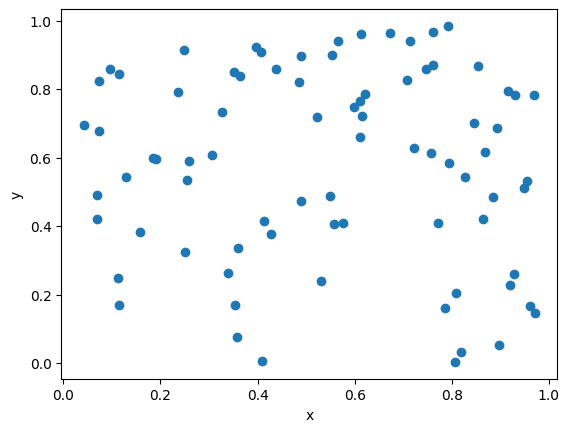

In [3]:
N = 80
points = np.random.random((N,2))

plt.scatter(points[:,0], points[:,1])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In the next cell, the distance matrix of the map is computed as

$$\text{distances}[i,j] = \lVert p_i - p_j \rVert$$

In [4]:
distances = np.array([[np.linalg.norm(points[i]-points[j]) for j in range(N)] for i in range(N)])

In the next cell, the ACO is used to find an optimal travelling salesman path. The hyperparameters used are $\alpha=1$, $\beta=2$ and $\rho=0.1$. 

In [5]:
aco = AntColonyOptimizer(distances, n_ants=50, n_epochs=100, alpha=1, beta=2, rho=0.1)
path_history = []
length_history = []
pheromone_history = []
path, length = aco.optimize(path_history, length_history, pheromone_history)
print('Optimal path:', path)
print('Optimal path length:', length)

Optimal path: [17  0 68 72 62 23 38 32 51 42 22 25 18  7 74 45 27 73 35 44 24  9 15 54
  4 16 60 52 47 70 33  5 46 41  1 56  3 75 19 50 57  6  2 48 61 13 63 76
 11 26 64 49 20 36 14 10 31 66 39 34 71 69 55 40 53 28 30 78 77 67 65 12
 43 58 59 37 29 21  8 79]
Optimal path length: 7.581783519776926


In the next cell, a chart is generated to show:
1. a visualization of the path found;
2. the evolution of the best path lengths over the epochs;
3. the evolution of the pheromone distribution entropy over the epochs.

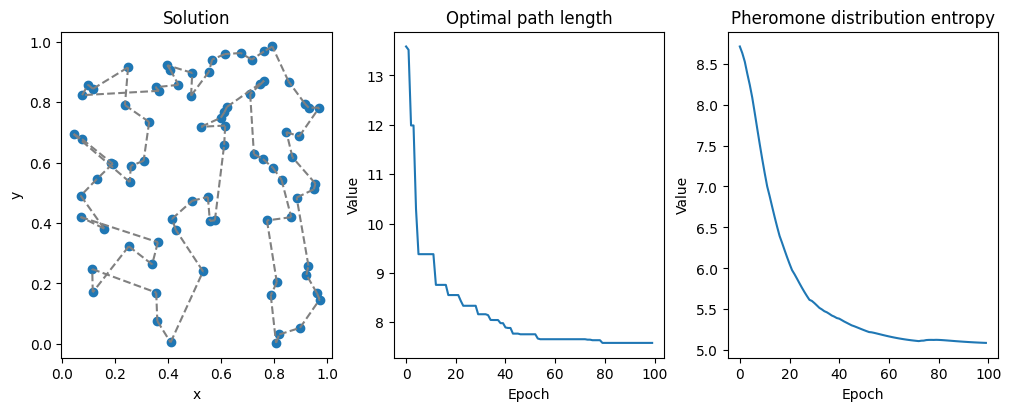

In [6]:
fig, ax = plt.subplots(ncols=3, figsize=(10,4), constrained_layout=True)

# --- Plot solution ---
for i in range(N-1):
    p1 = points[path[i], :]
    p2 = points[path[i+1], :]
    ax[0].plot([p1[0], p2[0]], [p1[1], p2[1]], color='gray', linestyle='dashed')

p1 = points[path[-1], :]
p2 = points[path[0], :]
ax[0].plot([p1[0], p2[0]], [p1[1], p2[1]], color='gray', linestyle='dashed')
ax[0].scatter(points[:,0], points[:,1])
ax[0].set_title('Solution')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

# --- Plot length history ---
ax[1].plot(length_history)
ax[1].set_title('Optimal path length')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Value')

# --- Plot pheromone distribution entropy history ---
pheromone_history = np.array(pheromone_history)
pheromone_history /= np.max(pheromone_history)
entropy_history = [entropy(pheromone_history[i].flatten()) for i in range(len(pheromone_history))]
entropy_history = np.array(entropy_history)

ax[2].plot(entropy_history)
ax[2].set_title('Pheromone distribution entropy')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Value')

plt.show()